In [1]:
import math
import numpy as np
import pandas as pd

In [2]:
df = pd.DataFrame({"x":[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
                   "y":[0, 0, 0, 1, 1, 0, 0, 0, 1, 1]})

### Where to split

Gain in purity:  
Cls: $\Delta$Gini  
Reg: MSE

In [27]:
def gini_impurity(proba):
    """Calculate the Gini impurity according to proba (y=1)"""
    p1 = proba
    p0 = 1 - proba
    return p0 * (1 - p0) + p1 * (1 - p1)

In [28]:
def gain_search(parent_node_value):
    """Search the best threshold with max gini gain"""
    thres_ls = []
    l_val_ls = []
    r_val_ls = []
    gain_ls = []
    
    for i in np.arange(0.5, 11.5, 1):
        left = df[df["x"] <= i]["y"]
        right = df[df["x"] > i]["y"]
        
        left_val = len(left) / 10 * gini_impurity(left.mean()) if len(left) > 0 else 0
        right_val = len(right) / 10 * gini_impurity(right.mean()) if len(right) > 0 else 0
        
        gain = parent_node_value - left_val - right_val
        
        thres_ls.append(i)
        l_val_ls.append(left_val)
        r_val_ls.append(right_val)
        gain_ls.append(gain)
        
    res = pd.DataFrame({"Threshold":thres_ls, 
                        "Left":l_val_ls, 
                        "Right":r_val_ls, 
                        "Total Gain":gain_ls})
    
    return res    

### How to calculate leaf node value

Cls: Majority class  
Reg: Average value of the samples

### 0 - Root node

In [29]:
node_0_gini = gini_impurity(df["y"].mean())
node_0_gini

0.48

In [30]:
gain_search(node_0_gini)

,Threshold,Left,Right,Total Gain
0,0.5,0.000000,0.480000,0.000000
1,1.5,0.000000,0.444444,0.035556
2,2.5,0.000000,0.400000,0.080000
3,3.5,0.000000,0.342857,0.137143
4,4.5,0.150000,0.300000,0.030000
5,5.5,0.240000,0.240000,0.000000
6,6.5,0.266667,0.200000,0.013333
7,7.5,0.285714,0.133333,0.060952
8,8.5,0.300000,0.000000,0.180000
9,9.5,0.400000,0.000000,0.080000


As we can see, when the threshold for **x** is 8.5, we got the highest gain, which is 0.18.  
When **x** < 8.5, the left majority is 0, while the right majority is 1.  

Therefore, our first tree would be:  
```
if x <=8.5:  
    y = 0  
else:  
    y = 1  
```

### Helper functions

In [70]:
def calc_res(df, f_col_name):
    """Convert F(x) to proba & calculate residual"""
    df["%s_proba"%f_col_name] = 1 / (1 + np.exp(-1 * df[f_col_name])) # F(x) -> proba
    df["res_%s"%f_col_name] = df["y"] - df["%s_proba"%f_col_name] # y - F(x)
    return df

### Initialization

In [76]:
f_0 = math.log((df["y"] == 1).sum() / (df["y"] == 0).sum())
f_0

-0.40546510810816444

In [77]:
tree = df.copy()

In [78]:
tree["f0"] = f_0
tree = calc_res(tree, "f0")

In [79]:
tree

,x,y,f0,f0_proba,res_f0
0,1,0,-0.405465,0.4,-0.4
1,2,0,-0.405465,0.4,-0.4
2,3,0,-0.405465,0.4,-0.4
3,4,1,-0.405465,0.4,0.6
4,5,1,-0.405465,0.4,0.6
5,6,0,-0.405465,0.4,-0.4
6,7,0,-0.405465,0.4,-0.4
7,8,0,-0.405465,0.4,-0.4
8,9,1,-0.405465,0.4,0.6
9,10,1,-0.405465,0.4,0.6


### Where to split

In [201]:
def se(thres, target_col):
    """Calculate Square Error to select the best split point"""
    left = tree[tree["x"] <= thres][target_col]
    right = tree[tree["x"] > thres][target_col]
    
    left_se = (np.zeros(len(left)) - np.repeat(left.mean(), len(left))) ** 2
    right_se = (np.ones(len(right)) - np.repeat(right.mean(), len(right))) ** 2
    
    return np.sum(left_se) + np.sum(right_se)

In [204]:
for i in np.arange(0.5, 11.5, 1):
    print(i, se(i, "y"))

0.5 3.5999999999999996
1.5 2.777777777777778
2.5 2.0
3.5 1.2857142857142858
4.5 1.75
5.5 2.6
6.5 1.6666666666666667
7.5 0.9047619047619048
8.5 0.5
9.5 1.0
10.5 1.6000000000000005


In [159]:
for i in np.arange(0.5, 11.5, 1):
    print(i, se(i, "y"))

0.5 3.5999999999999996
1.5 2.777777777777778
2.5 2.0
3.5 1.2857142857142858
4.5 1.75
5.5 2.6
6.5 1.6666666666666667
7.5 0.9047619047619048
8.5 0.5
9.5 1.0
10.5 1.6000000000000005


Therefore, the best threshold would be 8.5.

### Calculate leaf node value

In [82]:
def leaf_val(df, res_col_name, thres):
    """Calculate leaf node value (Newton-Raphson method)"""
    left_numerator  = df[df["x"] <= thres][res_col_name].sum()
    left_denominator = (df[df["x"] <= thres].apply(
        lambda r: (r["y"] - r[res_col_name]) * (1 - r["y"] + r[res_col_name]), axis=1)).sum()
    
    right_numerator  = df[df["x"] > thres][res_col_name].sum()
    right_denominator = (df[df["x"] > thres].apply(
        lambda r: (r["y"] - r[res_col_name]) * (1 - r["y"] + r[res_col_name]), axis=1)).sum()
    
    left_leaf_value = left_numerator / left_denominator
    right_leaf_value = right_numerator / right_denominator
    
    return left_leaf_value, right_leaf_value

In [84]:
left_leaf_value, right_leaf_value = leaf_val(tree, "res_f0", 8.5)
print("Left value:", left_leaf_value)
print("Right value:", right_leaf_value)

Left value: -0.6250000000000001
Right value: 2.5


### Update F(x)

Let's say we got an lr = 0.1

In [85]:
lr = 0.1

In [86]:
tree["f1"] = np.where(tree["x"] <= 8.5, 
                      tree["f0"] + left_leaf_value * lr, 
                      tree["f0"] + right_leaf_value * lr)

In [87]:
tree

,x,y,f0,f0_proba,res_f0,f1
0,1,0,-0.405465,0.4,-0.4,-0.467965
1,2,0,-0.405465,0.4,-0.4,-0.467965
2,3,0,-0.405465,0.4,-0.4,-0.467965
3,4,1,-0.405465,0.4,0.6,-0.467965
4,5,1,-0.405465,0.4,0.6,-0.467965
5,6,0,-0.405465,0.4,-0.4,-0.467965
6,7,0,-0.405465,0.4,-0.4,-0.467965
7,8,0,-0.405465,0.4,-0.4,-0.467965
8,9,1,-0.405465,0.4,0.6,-0.155465
9,10,1,-0.405465,0.4,0.6,-0.155465


### Repeat

In [88]:
tree = calc_res(tree, "f1")

In [89]:
tree

,x,y,f0,f0_proba,res_f0,f1,f1_proba,res_f1
0,1,0,-0.405465,0.4,-0.4,-0.467965,0.385098,-0.385098
1,2,0,-0.405465,0.4,-0.4,-0.467965,0.385098,-0.385098
2,3,0,-0.405465,0.4,-0.4,-0.467965,0.385098,-0.385098
3,4,1,-0.405465,0.4,0.6,-0.467965,0.385098,0.614902
4,5,1,-0.405465,0.4,0.6,-0.467965,0.385098,0.614902
5,6,0,-0.405465,0.4,-0.4,-0.467965,0.385098,-0.385098
6,7,0,-0.405465,0.4,-0.4,-0.467965,0.385098,-0.385098
7,8,0,-0.405465,0.4,-0.4,-0.467965,0.385098,-0.385098
8,9,1,-0.405465,0.4,0.6,-0.155465,0.461212,0.538788
9,10,1,-0.405465,0.4,0.6,-0.155465,0.461212,0.538788


In [103]:
left_leaf_value, right_leaf_value = leaf_val(tree, "res_f1", 8.5)
print("Left value:", left_leaf_value)
print("Right value:", right_leaf_value)

Left value: -0.5705211093125406
Right value: 2.1682011746071073


In [104]:
tree["f2"] = np.where(tree["x"] <= 8.5, 
                      tree["f1"] + left_leaf_value * lr, 
                      tree["f1"] + right_leaf_value * lr)

In [105]:
tree

,x,y,f0,f0_proba,res_f0,f1,f1_proba,res_f1,f2
0,1,0,-0.405465,0.4,-0.4,-0.467965,0.385098,-0.385098,-0.525017
1,2,0,-0.405465,0.4,-0.4,-0.467965,0.385098,-0.385098,-0.525017
2,3,0,-0.405465,0.4,-0.4,-0.467965,0.385098,-0.385098,-0.525017
3,4,1,-0.405465,0.4,0.6,-0.467965,0.385098,0.614902,-0.525017
4,5,1,-0.405465,0.4,0.6,-0.467965,0.385098,0.614902,-0.525017
5,6,0,-0.405465,0.4,-0.4,-0.467965,0.385098,-0.385098,-0.525017
6,7,0,-0.405465,0.4,-0.4,-0.467965,0.385098,-0.385098,-0.525017
7,8,0,-0.405465,0.4,-0.4,-0.467965,0.385098,-0.385098,-0.525017
8,9,1,-0.405465,0.4,0.6,-0.155465,0.461212,0.538788,0.061355
9,10,1,-0.405465,0.4,0.6,-0.155465,0.461212,0.538788,0.061355


In [106]:
tree = calc_res(tree, "f2")

In [107]:
tree

,x,y,f0,f0_proba,res_f0,f1,f1_proba,res_f1,f2,f2_proba,res_f2
0,1,0,-0.405465,0.4,-0.4,-0.467965,0.385098,-0.385098,-0.525017,0.371680,-0.371680
1,2,0,-0.405465,0.4,-0.4,-0.467965,0.385098,-0.385098,-0.525017,0.371680,-0.371680
2,3,0,-0.405465,0.4,-0.4,-0.467965,0.385098,-0.385098,-0.525017,0.371680,-0.371680
3,4,1,-0.405465,0.4,0.6,-0.467965,0.385098,0.614902,-0.525017,0.371680,0.628320
4,5,1,-0.405465,0.4,0.6,-0.467965,0.385098,0.614902,-0.525017,0.371680,0.628320
5,6,0,-0.405465,0.4,-0.4,-0.467965,0.385098,-0.385098,-0.525017,0.371680,-0.371680
6,7,0,-0.405465,0.4,-0.4,-0.467965,0.385098,-0.385098,-0.525017,0.371680,-0.371680
7,8,0,-0.405465,0.4,-0.4,-0.467965,0.385098,-0.385098,-0.525017,0.371680,-0.371680
8,9,1,-0.405465,0.4,0.6,-0.155465,0.461212,0.538788,0.061355,0.515334,0.484666
9,10,1,-0.405465,0.4,0.6,-0.155465,0.461212,0.538788,0.061355,0.515334,0.484666


### GBDT in sklearn

In [108]:
from sklearn.ensemble import gradient_boosting
from sklearn.tree import plot_tree

#### 2 trees, depth = 1

In [109]:
clf_1 = gradient_boosting.GradientBoostingClassifier(n_estimators=2, max_depth=1)

In [111]:
clf_1.fit(df[["x"]], df["y"])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=1,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=2,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [115]:
clf_1.predict_proba(df[["x"]])[:, 1]

array([0.37167979, 0.37167979, 0.37167979, 0.37167979, 0.37167979,
       0.37167979, 0.37167979, 0.37167979, 0.51533394, 0.51533394])

[Text(167.4, 163.07999999999998, 'X[0] <= 8.5\nfriedman_mse = 0.24\nsamples = 10\nvalue = -0.0'),
 Text(83.7, 54.360000000000014, 'friedman_mse = 0.188\nsamples = 8\nvalue = -0.625'),
 Text(251.10000000000002, 54.360000000000014, 'friedman_mse = -0.0\nsamples = 2\nvalue = 2.5')]

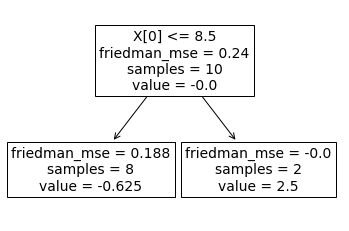

In [124]:
plot_tree(clf_1.estimators_[0][0])

[Text(167.4, 163.07999999999998, 'X[0] <= 8.5\nfriedman_mse = 0.223\nsamples = 10\nvalue = -0.0'),
 Text(83.7, 54.360000000000014, 'friedman_mse = 0.187\nsamples = 8\nvalue = -0.571'),
 Text(251.10000000000002, 54.360000000000014, 'friedman_mse = 0.0\nsamples = 2\nvalue = 2.168')]

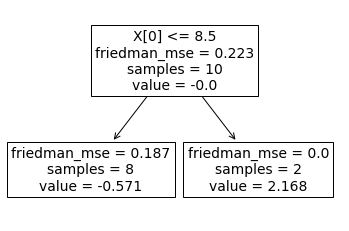

In [125]:
plot_tree(clf_1.estimators_[1][0])

In [128]:
clf_2 = gradient_boosting.GradientBoostingClassifier(n_estimators=1, max_depth=2)

In [130]:
clf_2.fit(df[["x"]], df["y"])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [131]:
clf_2.predict_proba(df[["x"]])[:, 1]

array([0.36074507, 0.36074507, 0.36074507, 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.46121182, 0.46121182])

[Text(200.88000000000002, 181.2, 'X[0] <= 8.5\nfriedman_mse = 0.24\nsamples = 10\nvalue = -0.0'),
 Text(133.92000000000002, 108.72, 'X[0] <= 3.5\nfriedman_mse = 0.188\nsamples = 8\nvalue = -0.15'),
 Text(66.96000000000001, 36.23999999999998, 'friedman_mse = -0.0\nsamples = 3\nvalue = -1.667'),
 Text(200.88000000000002, 36.23999999999998, 'friedman_mse = 0.24\nsamples = 5\nvalue = -0.0'),
 Text(267.84000000000003, 108.72, 'friedman_mse = -0.0\nsamples = 2\nvalue = 2.5')]

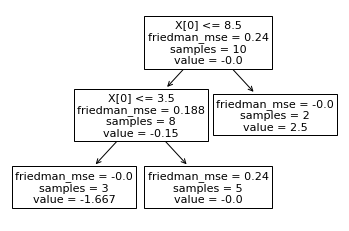

In [132]:
plot_tree(clf_2.estimators_[0][0])

In [135]:
clf_3 = gradient_boosting.GradientBoostingClassifier(n_estimators=5, max_depth=1)

In [136]:
clf_3.fit(df[["x"]], df["y"])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=1,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=5,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [137]:
clf_3.predict_proba(df[["x"]])[:, 1]

array([0.29256819, 0.29256819, 0.29256819, 0.38912579, 0.38912579,
       0.38912579, 0.38912579, 0.38912579, 0.59247127, 0.59247127])

[Text(167.4, 163.07999999999998, 'X[0] <= 8.5\nfriedman_mse = 0.24\nsamples = 10\nvalue = -0.0'),
 Text(83.7, 54.360000000000014, 'friedman_mse = 0.188\nsamples = 8\nvalue = -0.625'),
 Text(251.10000000000002, 54.360000000000014, 'friedman_mse = -0.0\nsamples = 2\nvalue = 2.5')]

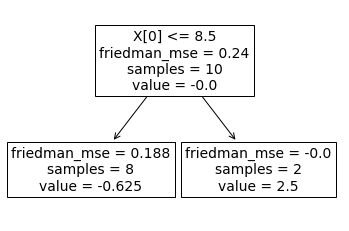

In [141]:
plot_tree(clf_3.estimators_[0][0])

[Text(167.4, 163.07999999999998, 'X[0] <= 8.5\nfriedman_mse = 0.223\nsamples = 10\nvalue = -0.0'),
 Text(83.7, 54.360000000000014, 'friedman_mse = 0.187\nsamples = 8\nvalue = -0.571'),
 Text(251.10000000000002, 54.360000000000014, 'friedman_mse = 0.0\nsamples = 2\nvalue = 2.168')]

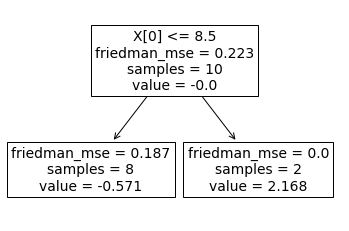

In [142]:
plot_tree(clf_3.estimators_[1][0])

[Text(167.4, 163.07999999999998, 'X[0] <= 3.5\nfriedman_mse = 0.209\nsamples = 10\nvalue = -0.0'),
 Text(83.7, 54.360000000000014, 'friedman_mse = 0.0\nsamples = 3\nvalue = -1.592'),
 Text(251.10000000000002, 54.360000000000014, 'friedman_mse = 0.214\nsamples = 7\nvalue = 0.666')]

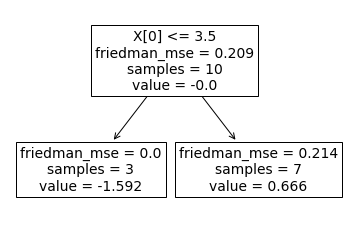

In [164]:
plot_tree(clf_3.estimators_[2][0])

[Text(167.4, 163.07999999999998, 'X[0] <= 8.5\nfriedman_mse = 0.198\nsamples = 10\nvalue = -0.001'),
 Text(83.7, 54.360000000000014, 'friedman_mse = 0.178\nsamples = 8\nvalue = -0.508'),
 Text(251.10000000000002, 54.360000000000014, 'friedman_mse = 0.0\nsamples = 2\nvalue = 1.88')]

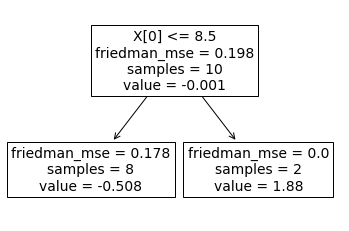

In [143]:
plot_tree(clf_3.estimators_[3][0])

[Text(167.4, 163.07999999999998, 'X[0] <= 3.5\nfriedman_mse = 0.187\nsamples = 10\nvalue = -0.001'),
 Text(83.7, 54.360000000000014, 'friedman_mse = 0.0\nsamples = 3\nvalue = -1.48'),
 Text(251.10000000000002, 54.360000000000014, 'friedman_mse = 0.204\nsamples = 7\nvalue = 0.582')]

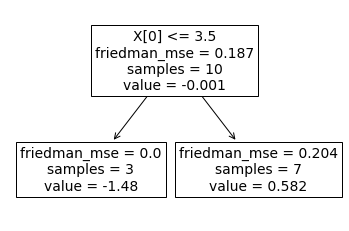

In [144]:
plot_tree(clf_3.estimators_[4][0])

In [192]:
df2 = pd.DataFrame({"x":[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
                    "y":[5.56, 5.7, 5.91, 6.4, 6.8, 7.05, 8.9, 8.7, 9, 9.05]})